# Initial exploration

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from featureNormalize import featureNormalize
from linearRegCostFunction import linearRegCostFunction
from linearRegLogCostFunction import linearRegLogCostFunction
from trainLinearReg import trainLinearReg
from plot2DFit import plot2DFit
from MyPlotterClass import MyPlotterClass
from dataFuncs import loadAndConvertData, lookAtMissingData

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

pos = [1920, 28, 1920, 1052]

myplots = MyPlotterClass(pos)
plt.style.use('yb_pres')

## The function loadAndConvertData loads the data into a dataframe and converts specific categorical fields into numerical values on a number scale. 

In [2]:
df,df_labels = loadAndConvertData('train.csv','train_labels.csv')

## Create correlation heat map of variables:

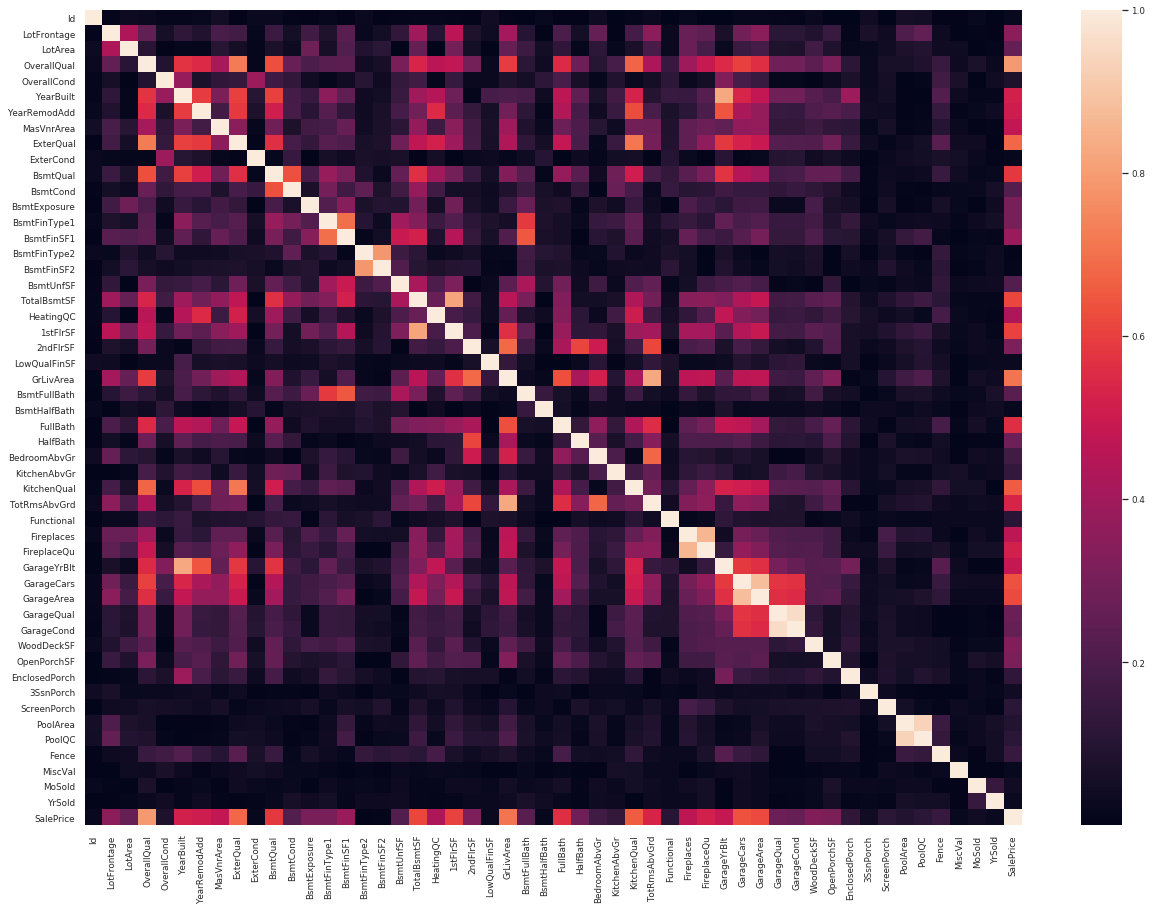

In [3]:
cov = df.cov() #covariance matrix: C_ij=sum[(xik - mui)(xjk-muj)]/(m-1), where m is the number of entries
corr = df.corr() #corellation matrix: R_ij=C_ij/sqrt(C_ii C_jj) = C_ij/(sig_i*sig_j)

plt.figure(figsize=(14*1.5,10*1.5))
#plt.get_current_fig_manager().window.setGeometry(pos[0],pos[1],pos[2],pos[3]) #Make fullscreen
sns.set(font_scale=.8)
ax = sns.heatmap(abs(corr),xticklabels=True,yticklabels=True)

## Order the variables from highest to lowest in terms of correlation with sales price:

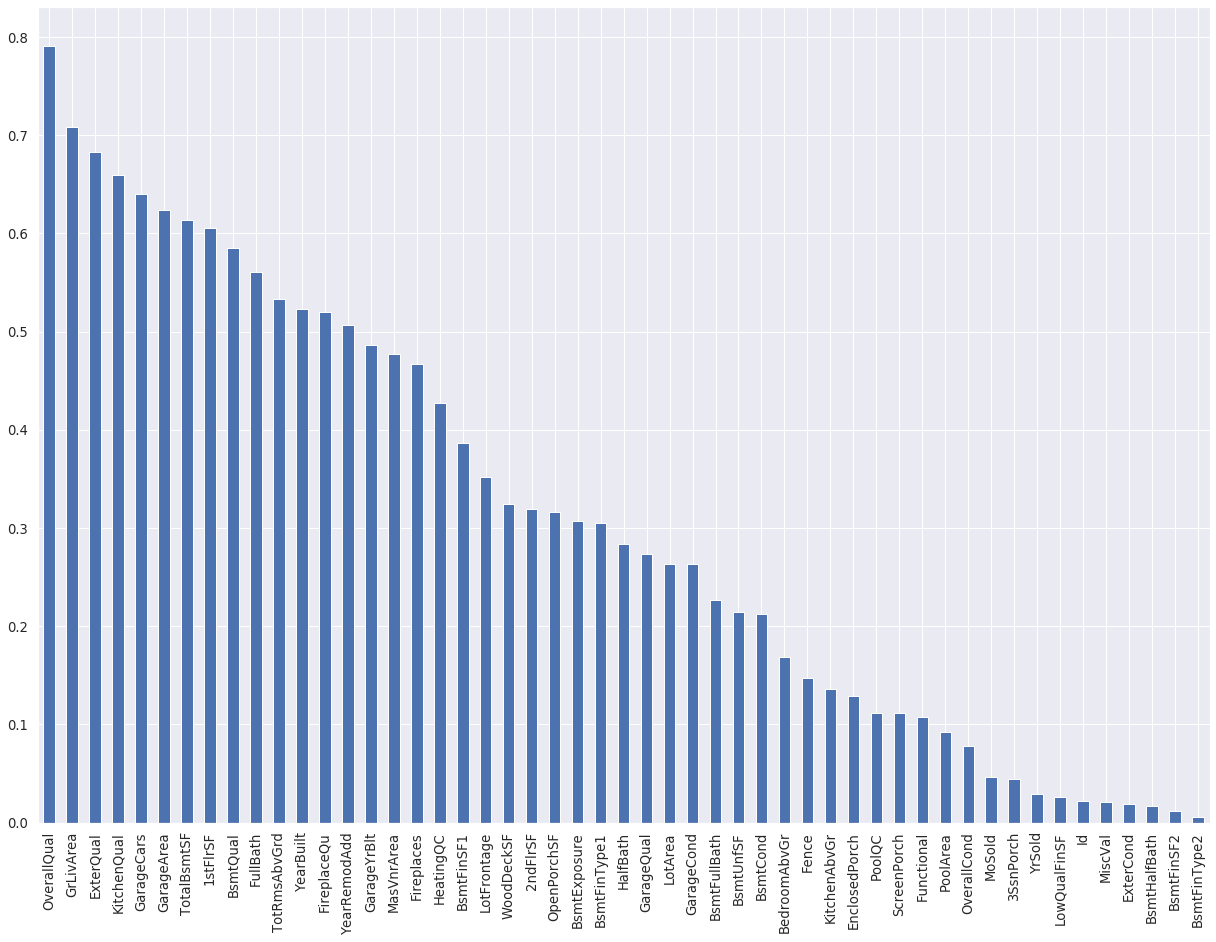

In [4]:
#create correlation chart of SalePrice vs variables
sp_corr = abs(corr['SalePrice'])
sp_corr.drop('SalePrice',inplace=True)#remove self-correlation term
sp_corr.dropna(inplace=True)#drop NaNs
sp_corr.sort_values(ascending=False,inplace=True)

#Visual of ordered corrlations 
plt.figure(figsize=(14*1.5,10*1.5))
sns.set(font_scale=1.2)
#plt.get_current_fig_manager().window.setGeometry(pos[0],pos[1],pos[2],pos[3]) #Make fullscreen
sp_corr.plot.bar()

plt.style.use('yb_pres') #somehow sns.set(font_scale) overwrites the style

## Look at distributions of top 3 variables and Sales Price

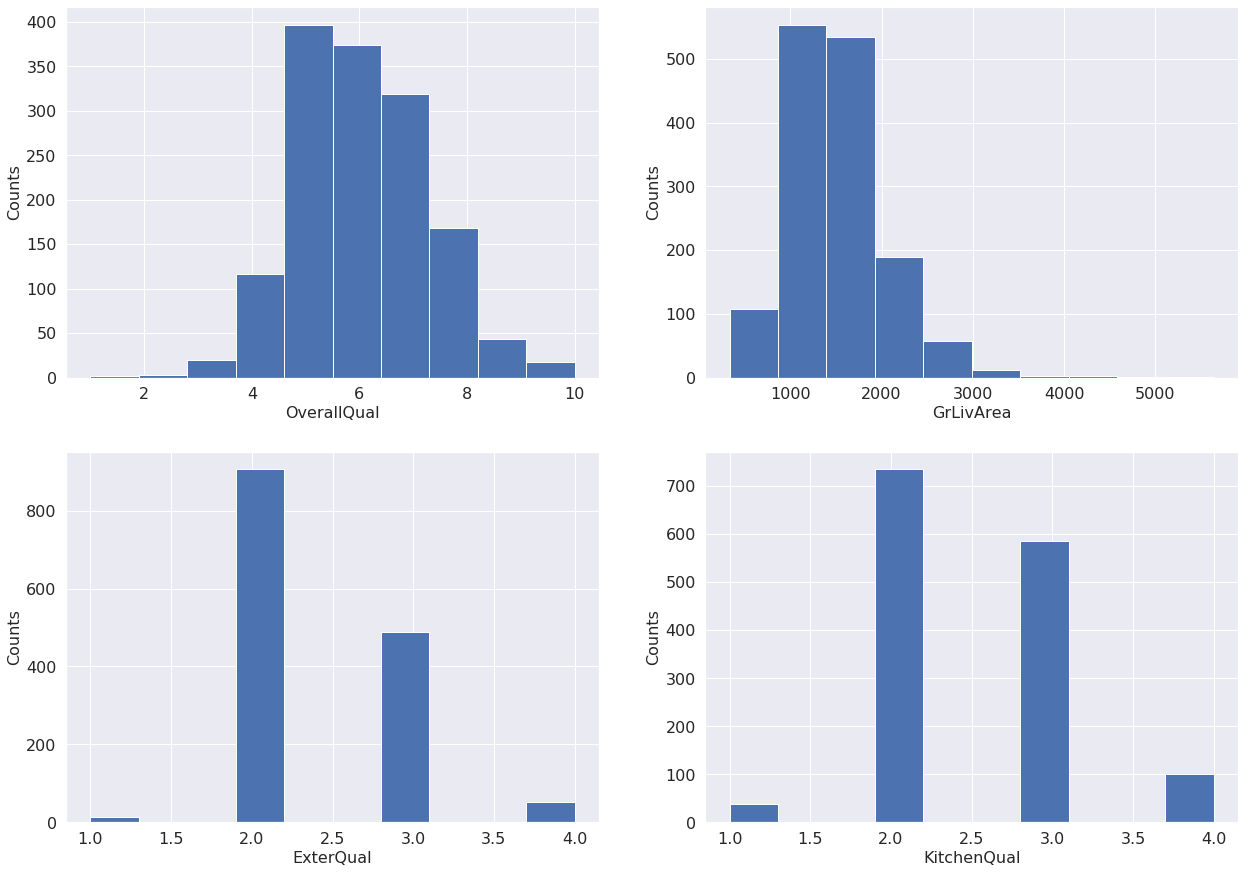

In [5]:
#%% Look at distributions of top 3 variables and Sales Price
myplots.plotDists(df,list(sp_corr.index)[0:4])

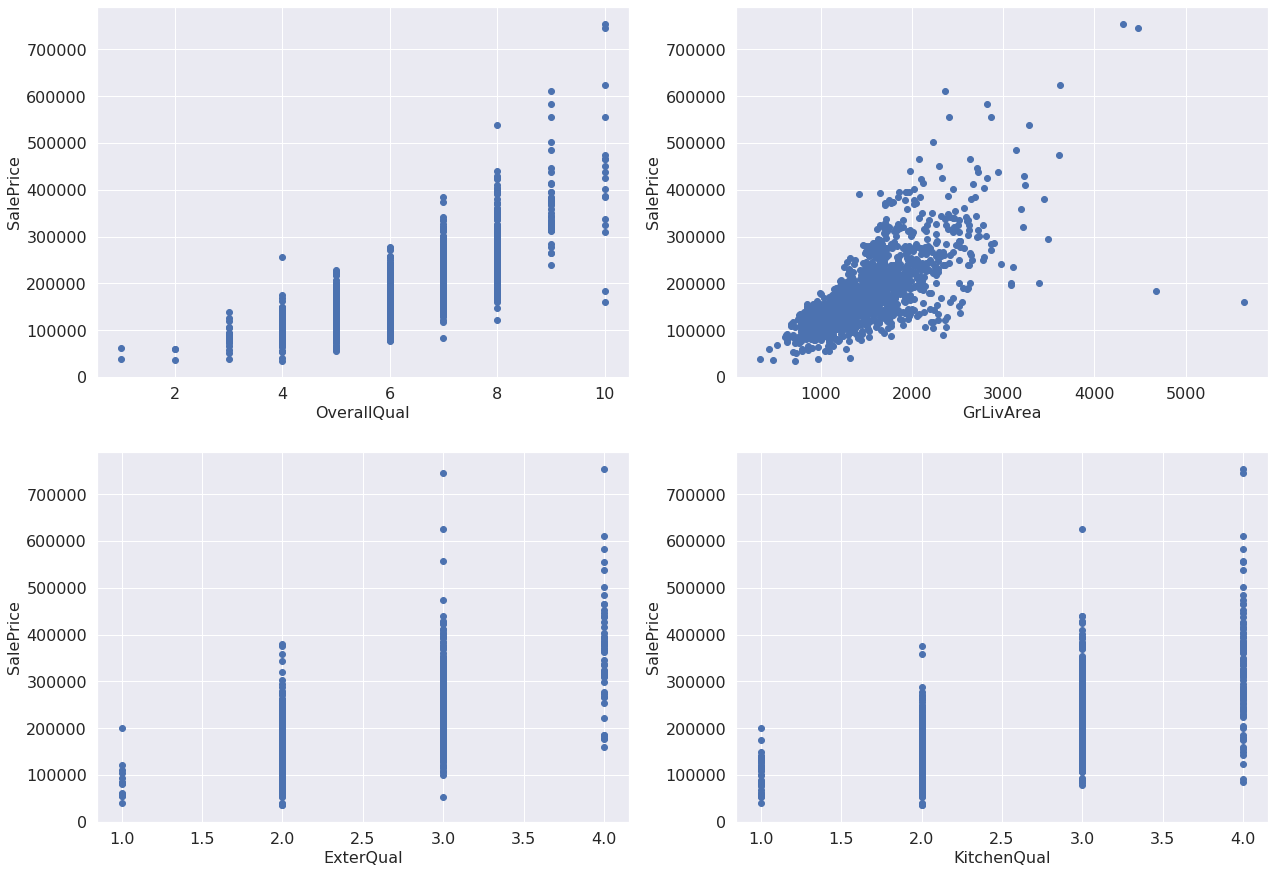

In [6]:
myplots.plotScatter(df,list(sp_corr.index)[0:4])

# Missing Data

Missing data equals nan (or -1 for converted numerical labels)

In [7]:
df_train = df
missing_data = lookAtMissingData(df_train)
missing_data

PoolQC          1453
MiscFeature     1406
Alley           1369
BsmtExposure    1326
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [8]:
df.shape

(1460, 81)

Dropping rows with missing values for the top-5 missing data features would throw out most of the data. Question is whether to keep or throw out these columns/features, or whether to throw out the individual entries with missing fields for these features.

To answer this, we examine the correlations between the features and sales price.

Text(0.5, 0.98, 'SalePrice vs Missing Numerical Fields')

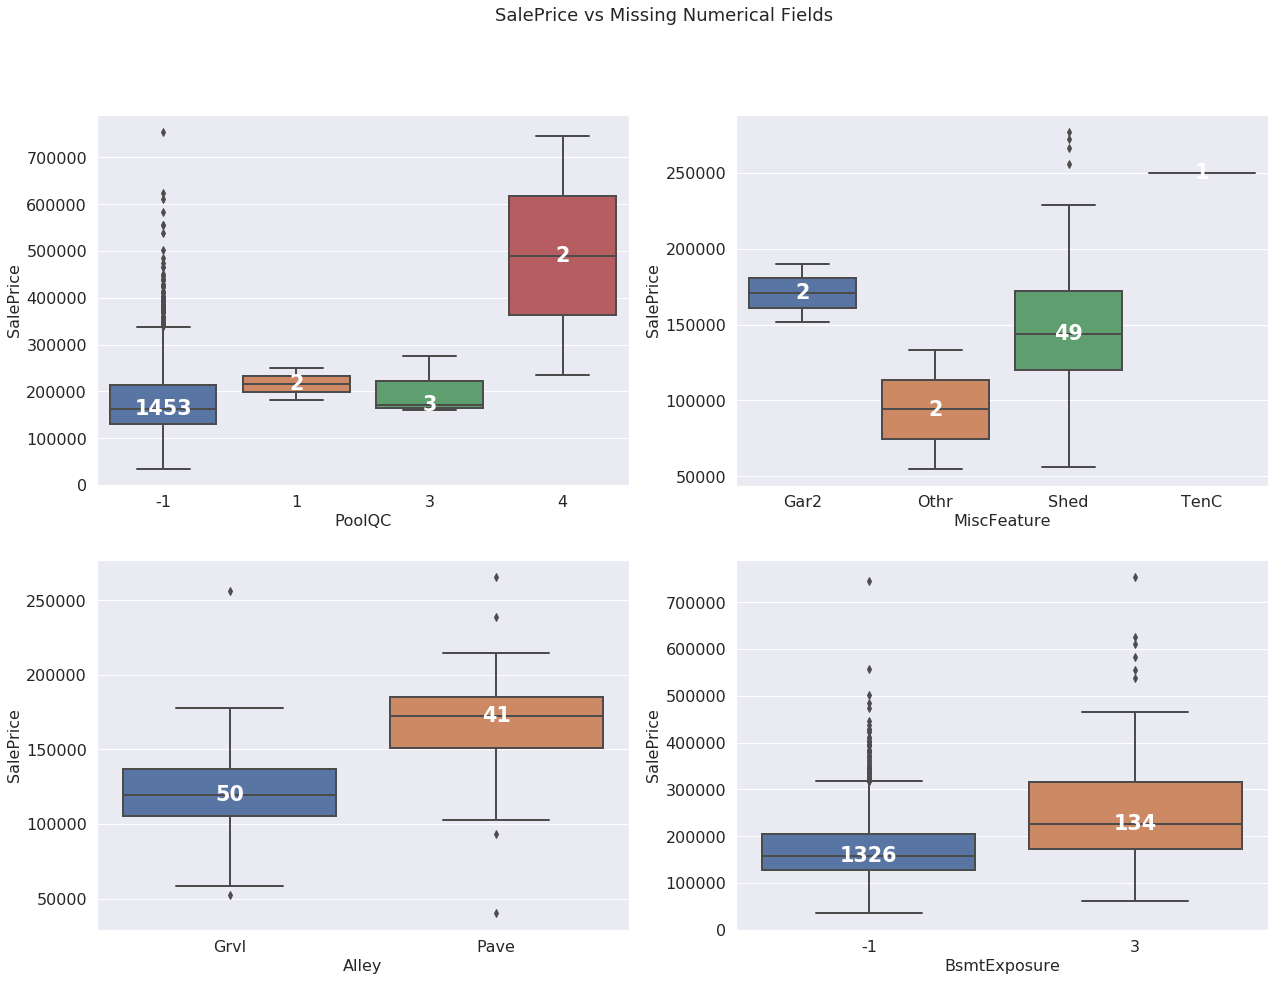

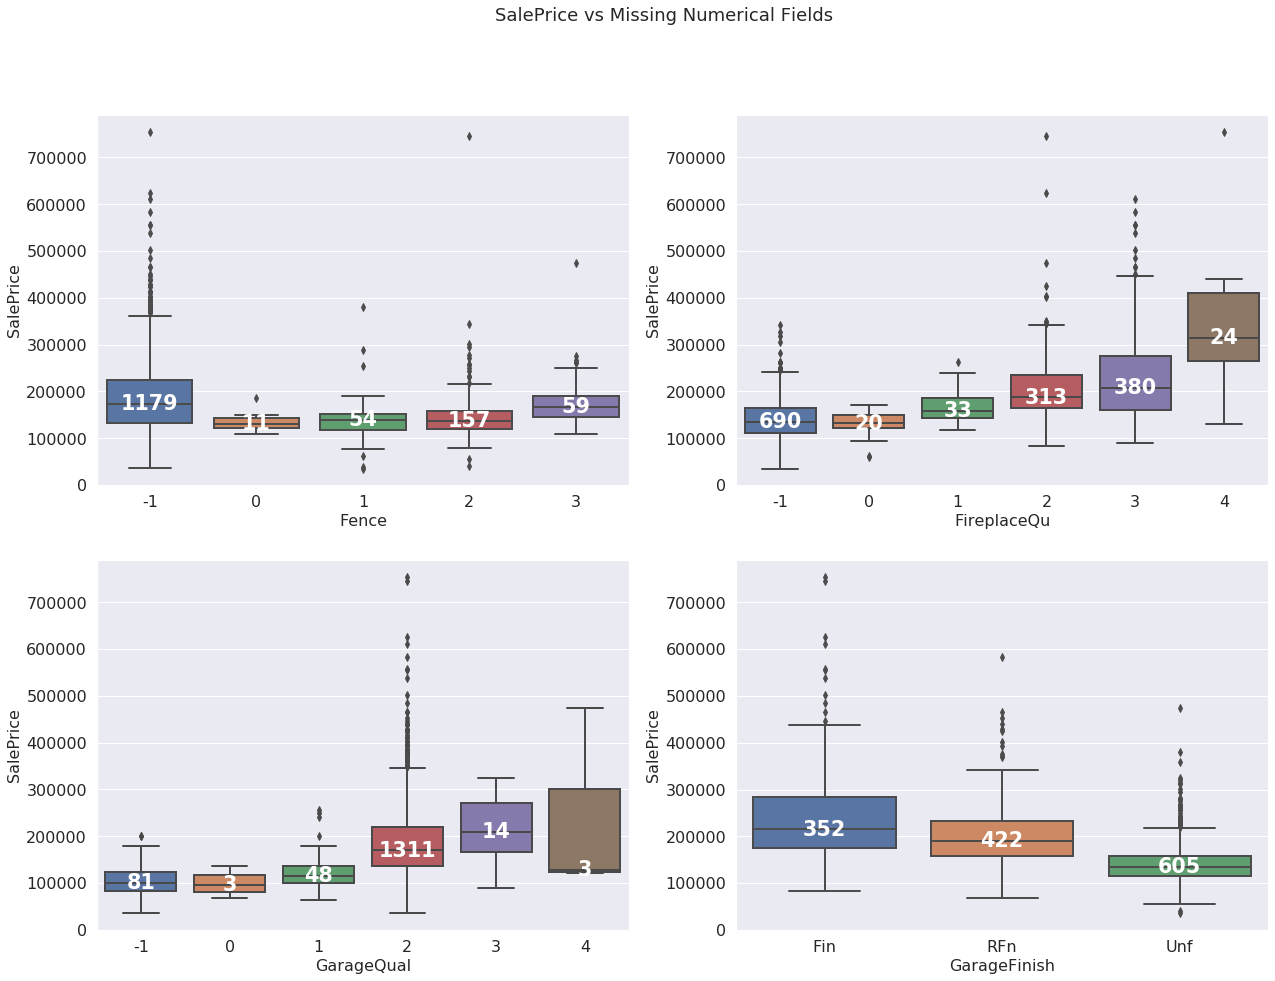

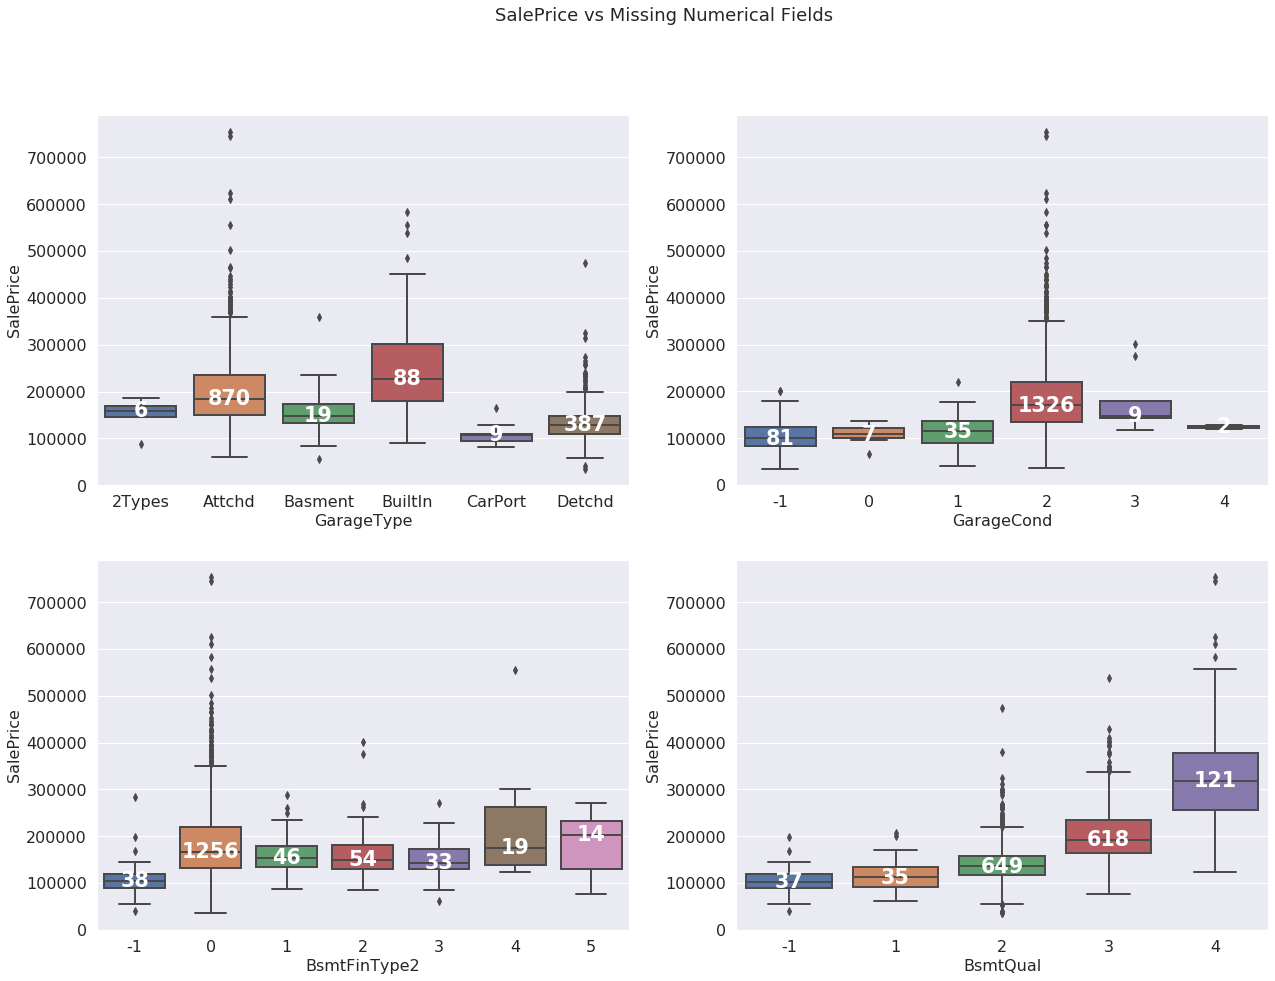

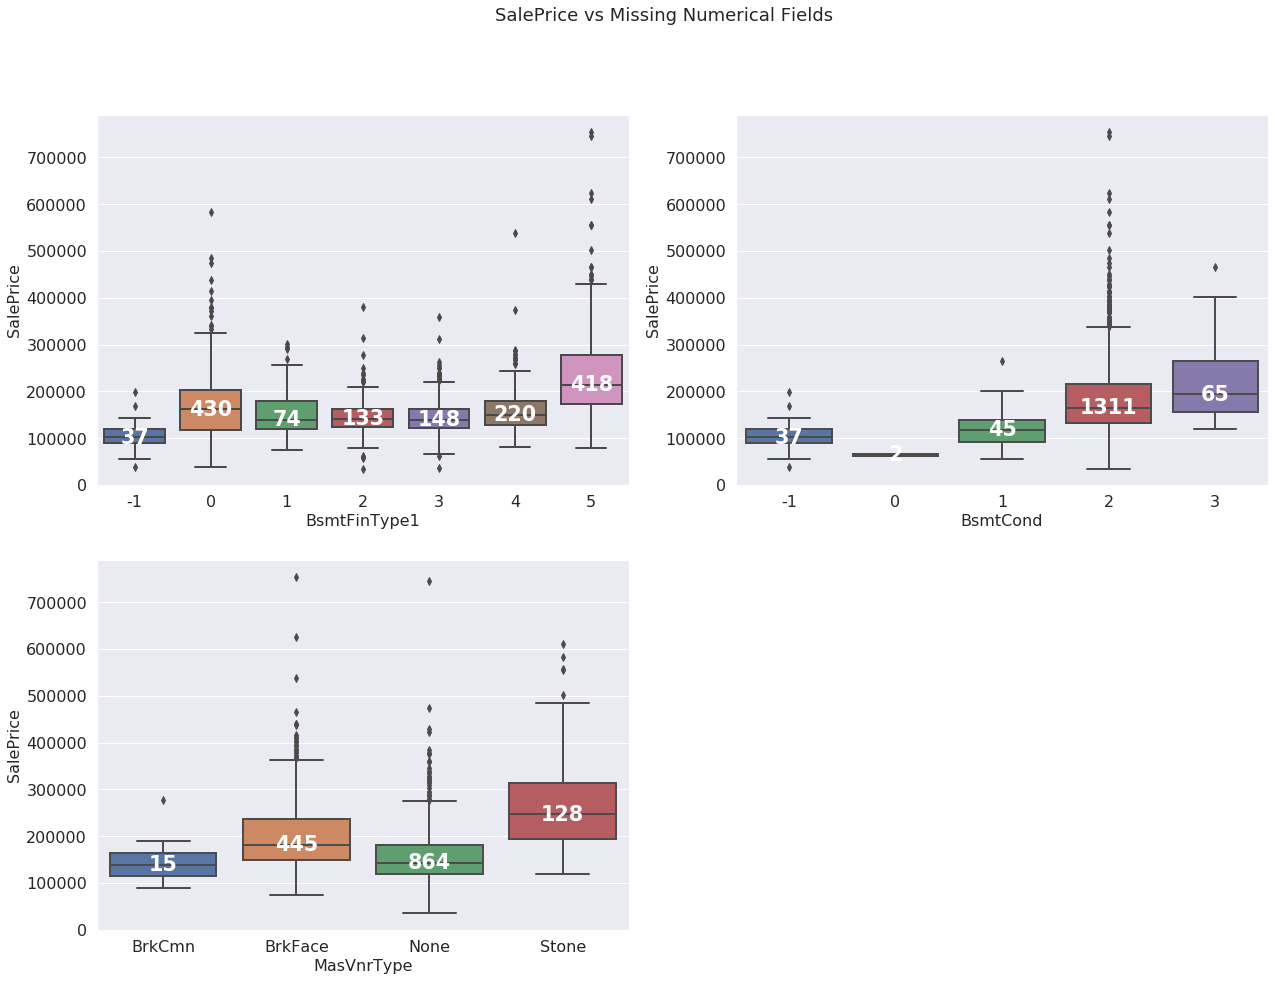

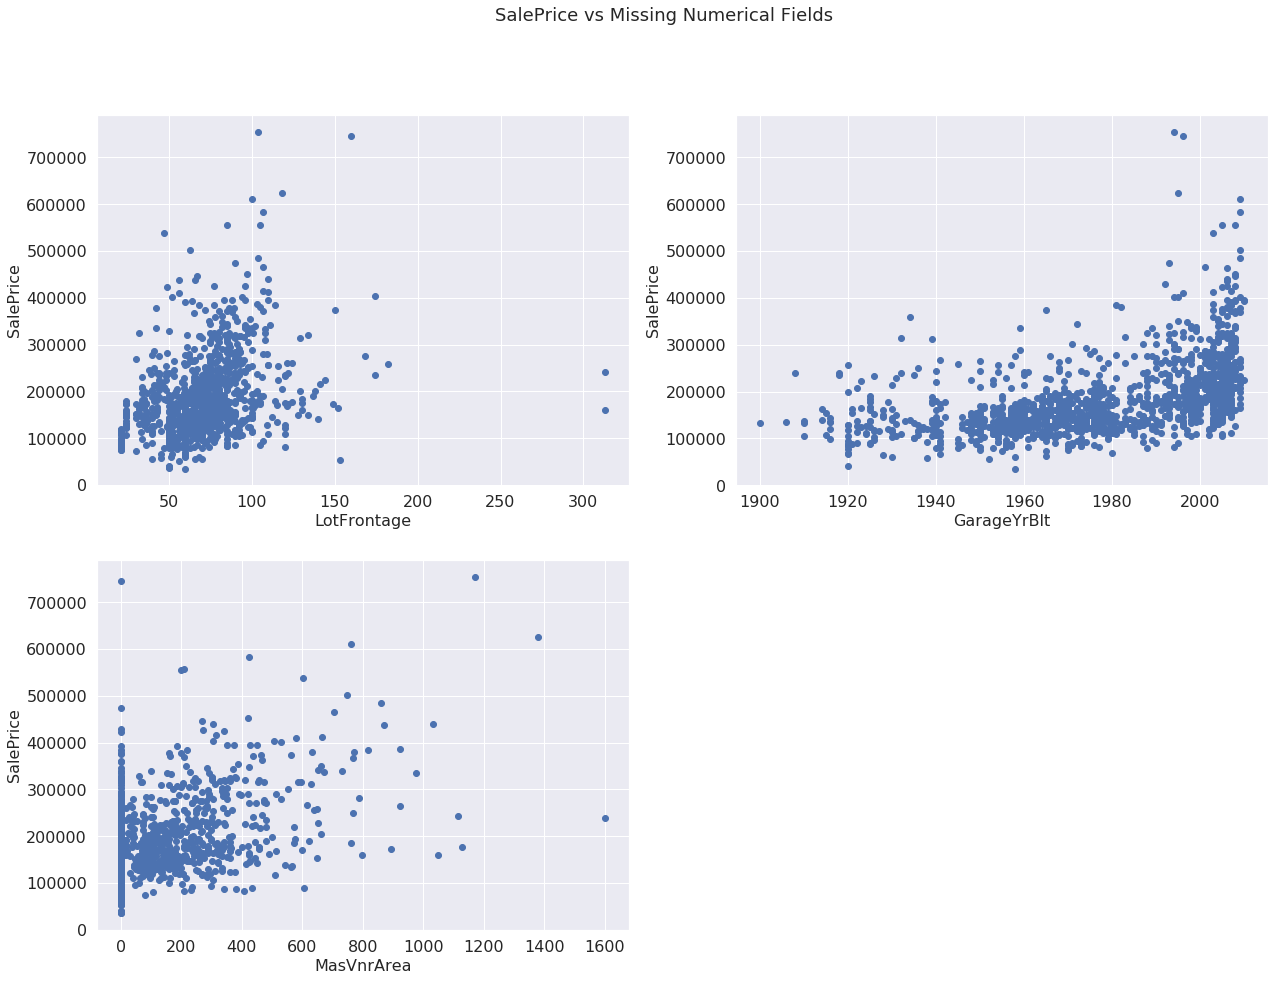

In [9]:
myplots.plotBoxplot(df,list(missing_data.index)[0:4])
plt.suptitle('SalePrice vs Missing Numerical Fields')
#PoolQC:with only 7 homes that have a pool, remove column
#MiscFeature-clearly not needed, remove column
#Alley, cat feature, could be used for a subset of data, but most don't have this, remove column
#BasementExposure has only one non-missing value, remove column


myplots.plotBoxplot(df,list(missing_data.index)[4:6]+list(missing_data.index)[7:9])
plt.suptitle('SalePrice vs Missing Numerical Fields')
#Fence, may be useful for categorical fitting, remove column
#Fireplace, same,remove column
#GarageQual, 81 homes don't have a garage or info on it. Doesn't correlate consistently, remove
#GarageFinish, could use in categorical fit, remove for now

myplots.plotBoxplot(df,list(missing_data.index)[9:10]+list(missing_data.index)[11:14])
plt.suptitle('SalePrice vs Missing Numerical Fields')
#GarageType, categorical
#GarageCond, doesn't correlate super well, remove
#BsmtFinType2, same, remove
#BsmtQual, could be included in regression, keep

myplots.plotBoxplot(df,list(missing_data.index)[14:16]+list(missing_data.index)[17:18])
plt.suptitle('SalePrice vs Missing Numerical Fields')
#GBsmtFinType1, doesn't correlate super well, remove
#BstmtCond, could be included in regression, keep
#MasVnrType, cat data
myplots.plotScatter(df,['LotFrontage','GarageYrBlt','MasVnrArea'])
plt.suptitle('SalePrice vs Missing Numerical Fields')



## Drop columns and rows
For regression, including the top 7 column values will cost a lot of data. We opt to drop these columns in order to keep most of the data.

In [10]:
list(missing_data.index)[0:7]

['PoolQC',
 'MiscFeature',
 'Alley',
 'BsmtExposure',
 'Fence',
 'FireplaceQu',
 'LotFrontage']

In [11]:
df_train.drop(columns = list(missing_data.index)[0:7],inplace=True)
missing_data = lookAtMissingData(df_train)
missing_data

GarageFinish    81
GarageYrBlt     81
GarageType      81
GarageCond      81
GarageQual      81
BsmtFinType2    38
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

The basement and garage variables correspond to houses without basements/garages or no info on them. For now, drop these eneries but could include with tree-based methods.

In [12]:
df_train.dropna(inplace = True)
missing_data = lookAtMissingData(df_train)
missing_data

BsmtFinType2    31
BsmtQual        30
BsmtCond        30
BsmtFinType1    30
dtype: int64

In [13]:
df_train = df_train[df_train.BsmtFinType2!=-1].dropna()
missing_data = lookAtMissingData(df_train)
missing_data

Series([], dtype: int64)

Maybe half of the data is categrical

In [18]:
df_cat = df_train.select_dtypes('category')
[df_cat[el].dtypes for el in df_cat.columns]

[CategoricalDtype(categories=[20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 160, 180,
                   190],
                  ordered=False),
 CategoricalDtype(categories=['C (all)', 'FV', 'RH', 'RL', 'RM'], ordered=False),
 CategoricalDtype(categories=['Grvl', 'Pave'], ordered=False),
 CategoricalDtype(categories=['IR1', 'IR2', 'IR3', 'Reg'], ordered=False),
 CategoricalDtype(categories=['Bnk', 'HLS', 'Low', 'Lvl'], ordered=False),
 CategoricalDtype(categories=['AllPub', 'NoSeWa'], ordered=False),
 CategoricalDtype(categories=['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], ordered=False),
 CategoricalDtype(categories=['Gtl', 'Mod', 'Sev'], ordered=False),
 CategoricalDtype(categories=['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
                   'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR',
                   'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes',
                   'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer',
                   'SawyerW', '

Focus on Numerical data first...

# Regression on Numerical Data

In [19]:
df_num = df_train.select_dtypes('int64','float64')
y = df_num.SalePrice.values
df_num.drop(columns=['SalePrice','Id'],inplace=True)
df_num.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

### Try PCA on numerical variables

Below, we normalize the features before performing PCA. Keeping 99% of the variance results in reducing the dimension of our data from 43 to 37 principal components. We apply the transformation to obtain our new training set X in terms of the new eigenvector represenatation, which we will perform regression on. 

In principle, this doesn't add much, but we proceed.

In [21]:

#normalize features
df_train_norm,_,_ = featureNormalize(df_num)
#%%
from pca import pca
#  Run PCA
U, S, V = pca(df_train_norm.values)
plt.figure();
p=np.cumsum(S)/np.sum(S) #Fraction of total variance
plt.plot(p)
plt.xlabel('Component Inclusion')
plt.ylabel('Fraction of Total Variance')

#Find component where 99% of variance accumulated
ind = np.argwhere(p>.99)[0]
#Total reduction in this case is from 42 to 37 components
#This wouldn't aid in visualization nor faster fitting, so PCA doesn't help much here.
#Still we can find the new representation for our data as follows
Ureduce = U[:,0:ind[0]]
X = np.matmul(Ureduce.T,df_train_norm.values.T).T

In [22]:
%matplotlib qt
#%%Perform regularized regression 
X = np.matmul(Ureduce.T,df_train_norm.values.T).T
X = np.column_stack((np.ones(X.shape[0]), X))
# Initialize Theta
initial_theta = np.random.rand(X.shape[1])
initial_theta[0]=50000

Lambda=1.0
labels = ['BasePrice']+ list(df_num.columns)
theta = trainLinearReg(X, y, Lambda,initial_theta,labels,maxiter=200)
fig = plt.gcf()
fig.set_size_inches(12*2,3*2)

         Current function value: 575394664.757285
         Iterations: 52
         Function evaluations: 152
         Gradient evaluations: 141


In [23]:
#plot results using top 2 principal components
ax = plot2DFit(X,y,theta)
#error_train, _ =linearRegCostFunction(X,y,theta,0)
error_train, _ =linearRegLogCostFunction(X,y,theta,0)
print('Error Train = ' + str(error_train))

Error Train = 0.013133800753502779


### Working with the old representation...

         Current function value: 571780398.318177
         Iterations: 77
         Function evaluations: 179
         Gradient evaluations: 170
Error Train MSE = 571360557.0868622
Error Train LogLoss = 0.013324678654135913


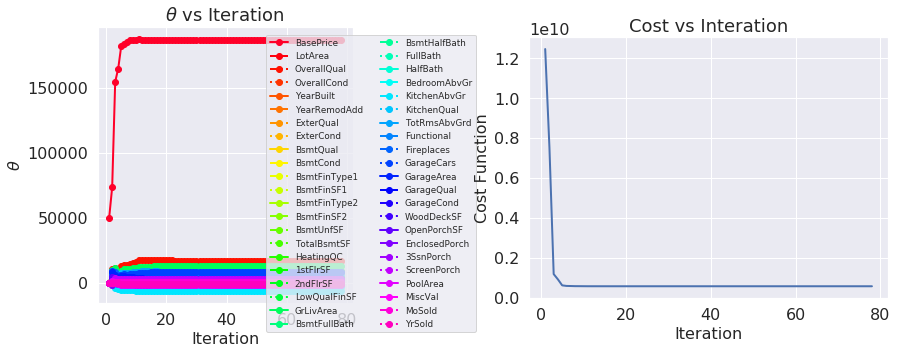

In [26]:
#Select top 2 variables correlated with SalePrice
#ss=sp_corr.index.values[0:2]
#df_num = df_num[ss]

#normalize features
df_train_norm = featureNormalize(df_num)
X = df_train_norm.values


#%%Perform regularized regression on all features 
X = np.column_stack((np.ones(X.shape[0]), X))
# Initialize Theta
initial_theta = np.random.rand(X.shape[1])
initial_theta[0]=50000

Lambda=1.0
labels = ['BasePrice']+ list(df_num.columns)
theta = trainLinearReg(X, y, Lambda,initial_theta,labels,maxiter=200)

#error_train, _ =linearRegCostFunction(X,y,theta,0)
error_train, _ =linearRegCostFunction(X,y,theta,0)
print('Error Train MSE = ' + str(error_train))
error_train, _ =linearRegLogCostFunction(X,y,theta,0)
print('Error Train LogLoss = ' + str(error_train))


Note: A nan might occur because of taking a log of a negative number in the Log version of the cost function used to compute the training error. The precise entries causing this error can be found using the presciptions below. These arise when the 1st degree polynomial model predicts negative sales price for these entries, since it is only linear in the features.

In [27]:
ind = np.argwhere(np.isnan(np.log(np.matmul(X,theta))))
if len(ind)==0:
    print('No nans')
else:   
    df_num.iloc[ind[0]]
    df_num.iloc[ind[1]]
    np.matmul(X[ind,:],theta)

No nans


# 2nd order polynomial features.

In [28]:
#This is to debug featureNormalize().Ignore.
from sklearn.preprocessing import PolynomialFeatures
polymap = PolynomialFeatures(2,include_bias=False)
X = polymap.fit_transform(df_num.values)

print(X.shape)

X = featureNormalize(X)
X = X[:,0:42]
print(X.shape)
X0 = df_num.values
X0 = featureNormalize(X0)

polymap.get_feature_names(list(df_num.columns))[0:42]
print(X[0,0:10])
print(X0[0,0:10])

(1339, 989)
(1339, 42)
[-0.21867508  0.58904099 -0.55313185  1.01343946  0.85372767  0.99368126
 -0.27954065  0.5877083  -0.05905705  1.13286291]
[-0.21867508  0.58904099 -0.55313185  1.01343946  0.85372767  0.99368126
 -0.27954065  0.5877083  -0.05905705  1.13286291]


/media/yelena/storage/Documents/Python/KaggleHousingPrices/featureNormalize.py:12: RuntimeWarning: divide by zero encountered in true_divide
  dout = dout/dout.std(axis=0)
/media/yelena/storage/Documents/Python/KaggleHousingPrices/featureNormalize.py:12: RuntimeWarning: invalid value encountered in true_divide
  dout = dout/dout.std(axis=0)


When generating polynomial features, a divide by zero error is thrown when the standard devation of the features is zero (meaning all values are the same). These columns do not add information for regression and can be dropped.They commonly occur when two columns have very few non-zero entries such that the element-wise product is zero for all entries.

In [29]:
from sklearn.preprocessing import PolynomialFeatures
polymap = PolynomialFeatures(2,include_bias=False)
X = polymap.fit_transform(df_num.values)
X = featureNormalize(X)

#X = X[:,0:42]
#Delete nan columns generated by featureNormalize when dividing by the standard deviation of identical features.
sum(sum(np.isnan(X)))
nanfeatures = np.argwhere(np.isnan(X[0,:]))
featurenames = polymap.get_feature_names(list(df_num.columns))
featurenames = np.array(featurenames)
[print(featurenames[i]) for i in nanfeatures]
X = np.delete(X,nanfeatures,axis=1)
featurenames = np.delete(featurenames,nanfeatures)
print('Nans remaining:' + str(sum(sum(np.isnan(X)))))
X = np.column_stack((np.ones(X.shape[0]), X))

['3SsnPorch ScreenPorch']
['3SsnPorch PoolArea']
Nans remaining:0


/media/yelena/storage/Documents/Python/KaggleHousingPrices/featureNormalize.py:12: RuntimeWarning: divide by zero encountered in true_divide
  dout = dout/dout.std(axis=0)
/media/yelena/storage/Documents/Python/KaggleHousingPrices/featureNormalize.py:12: RuntimeWarning: invalid value encountered in true_divide
  dout = dout/dout.std(axis=0)


Below, the error is much improved but we are certaintly overfitting. The next step could be to try PCA on the polynomial features.

         Current function value: 148338409.038884
         Iterations: 200
         Function evaluations: 315
         Gradient evaluations: 315
Error Train MSE = 145845016.35835677
Error Train LogLoss = 0.004504352821752997


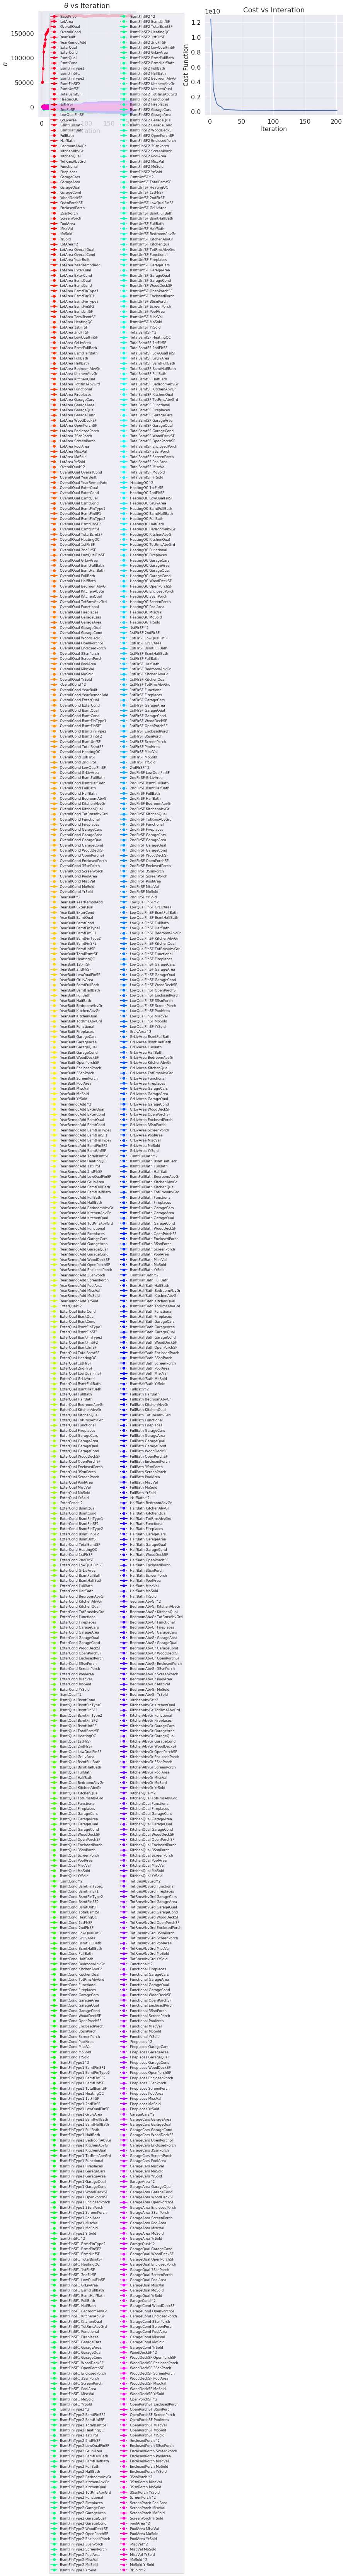

In [30]:
# Initialize Theta
initial_theta = np.random.rand(X.shape[1])
initial_theta[0]=50000

Lambda=1.0
labels = ['BasePrice']+ list(featurenames)
theta = trainLinearReg(X, y, Lambda,initial_theta,labels,maxiter=200)

error_train, _ =linearRegCostFunction(X,y,theta,0)
print('Error Train MSE = ' + str(error_train))
error_train, _ =linearRegLogCostFunction(X,y,theta,0)
print('Error Train LogLoss = ' + str(error_train))

## Try PCA on polynomial features

Below we see that PCA is able to reduce our 944 polynomial features to 154 that account for 99% of the variance in the data set. This leads to a worse training error than without the reduction but is still an improvement over the 43 linear features as expected. 99% may be more than we need to account for and we may wish to reducte the dimensionality even more to prevent over-fitting. To see where we are with this, we ought to bring in the test data set. 

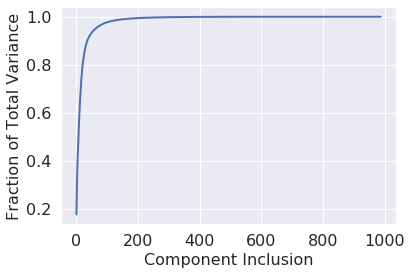

In [31]:
from pca import pca
#  Run PCA
U, S, V = pca(X)
plt.figure();
p=np.cumsum(S)/np.sum(S) #Fraction of total variance
plt.plot(p)
plt.xlabel('Component Inclusion')
plt.ylabel('Fraction of Total Variance')

#Find component where 99% of variance accumulated
ind = np.argwhere(p>.99)[0]
Ureduce = U[:,0:ind[0]]
X = np.matmul(Ureduce.T,X.T).T

         Current function value: 263313483.665093
         Iterations: 200
         Function evaluations: 318
         Gradient evaluations: 318
Error Train MSE = 249894550.2383232
Error Train LogLoss = 0.00728266001163777


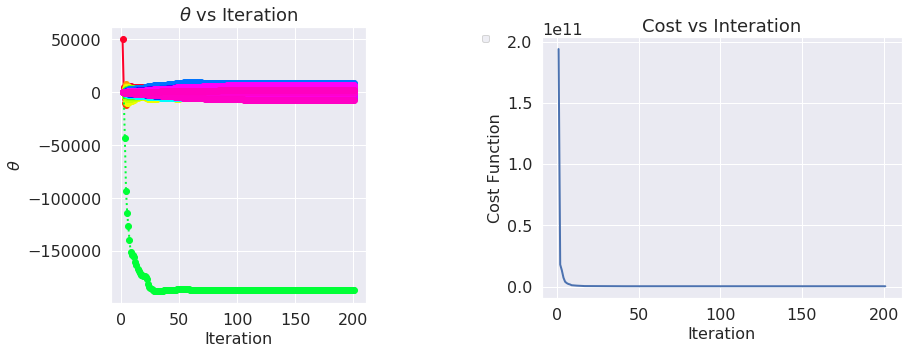

In [32]:
# Initialize Theta
initial_theta = np.random.rand(X.shape[1])
initial_theta[0]=50000

Lambda=1.0
labels = ['BasePrice']+ list(featurenames)
theta = trainLinearReg(X, y, Lambda,initial_theta,labels=[],maxiter=200)

error_train, _ =linearRegCostFunction(X,y,theta,0)
print('Error Train MSE = ' + str(error_train))
error_train, _ =linearRegLogCostFunction(X,y,theta,0)
print('Error Train LogLoss = ' + str(error_train))

# Categorical Data Starting Point...
About half of the data is categrical. We convert this non-ordered cat data into numerical using get_dummies().

For the training set we go from 27 cat features to 190.
For the test set we go from 27 to 176.

This means that not every possible cat value is present in the test set. 

In [ ]:
df_cat = df_train.select_dtypes('category')
[df_cat[el].dtypes for el in df_cat.columns]

df_cat_dummies = pd.get_dummies(df_cat)
print(df_cat.shape)
print(df_cat_dummies.shape)